In [0]:
import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf

from google.colab import drive

from os import listdir

from keras import backend as K
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

from keras_applications.resnext import ResNeXt50

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer

In [0]:
drive.mount('/content/drive')
%cd drive/'My Drive'/deeplearn-classroom

In [0]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((224, 224))
image_size = 0
directory_root = './plantvillage/'

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [0]:
image_list, label_list = [], []
try:
    print("Loading tomato leaf images ..")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"Processing: {plant_disease_folder} ..")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("Image loading completed.")  
except Exception as e:
    print(f"Error : {e}")

Loading tomato leaf images ..
Processing: Tomato___Spider_mites Two-spotted_spider_mite ..
Processing: Tomato___Tomato_mosaic_virus ..
Processing: Tomato___Septoria_leaf_spot ..
Processing: Tomato___Early_blight ..
Processing: Tomato___Bacterial_spot ..
Processing: Tomato___Leaf_Mold ..
Processing: Tomato___Target_Spot ..
Processing: Tomato___Tomato_Yellow_Leaf_Curl_Virus ..
Processing: Tomato___healthy ..
Processing: Tomato___Late_blight ..
Image loading completed.


In [0]:
image_size = len(image_list)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

In [0]:
print("Normalizing data ..")
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

Normalizing data ..


In [0]:
print("Spliting data to training data and testing data ..")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 
print("Splitting completed.")

Spliting data to training data and testing data ..
Splitting completed.


In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
#base model
resnext = ResNeXt50(input_tensor=Input(shape = (224, 224, 3)), include_top = False, weights = None, 
        backend = keras.backend, layers = keras.layers, models = keras.models, utils = keras.utils)

#top layer
toplayer = Dense(n_classes, activation='softmax')(GlobalAveragePooling2D()(resnext.output))

#joining base model and top layer
model = Model(inputs=resnext.input, outputs=toplayer)

In [0]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS), metrics=["accuracy"])

In [0]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/100
50/50 [==============================] - 95s 2s/step - loss: 2.3772 - acc: 0.3775 - val_loss: 14.3451 - val_acc: 0.1100
Epoch 2/100
50/50 [==============================] - 57s 1s/step - loss: 1.2384 - acc: 0.5994 - val_loss: 9.8600 - val_acc: 0.1800
Epoch 3/100
50/50 [==============================] - 57s 1s/step - loss: 1.2038 - acc: 0.6294 - val_loss: 14.1455 - val_acc: 0.1150
Epoch 4/100
50/50 [==============================] - 57s 1s/step - loss: 1.1298 - acc: 0.6406 - val_loss: 14.2626 - val_acc: 0.1050
Epoch 5/100
50/50 [==============================] - 57s 1s/step - loss: 0.8859 - acc: 0.7056 - val_loss: 11.4935 - val_acc: 0.1350
Epoch 6/100
50/50 [==============================] - 57s 1s/step - loss: 0.8539 - acc: 0.7069 - val_loss: 10.7253 - val_acc: 0.1375
Epoch 7/100
50/50 [==============================] - 57s 1s/step - loss: 1.0776 - acc: 0.6787 - val_loss: 9.8335 - val_acc: 0.1175
Epoch 8/100
50/50 [==============================] - 57s 1s/step - loss: 1.012

In [0]:
# Save the moel as a pickle in a file 
joblib.dump(model, 'ResNeXt50-tomatoleaf.pkl')

['ResNeXt50-tomatoleaf.pkl']

In [0]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

400/400 [==============================] - 3s 8ms/step
Test Accuracy: 75.25


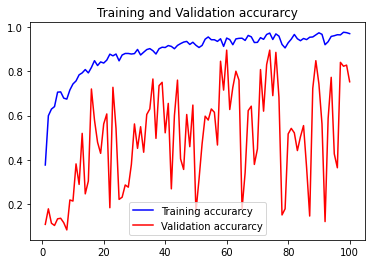

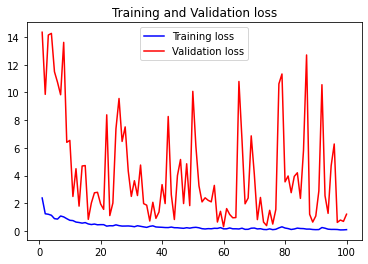

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [0]:
img = cv2.imread('tomat.jpg')
img = cv2.resize(img,(224,224))
img = np.reshape(img,[1,224,224,3])

In [0]:
def predict(image):
    try:
        lab = label_binarizer.classes_
        pred = model.predict(image)
        for cls in pred:
          for x in range(0,10):
            print(lab[x],cls[x])
            if cls[x] > 0:
              positive = lab[x]
        print(f"\nThe image is predicted to be positive for : {positive} disease")
    except Exception as e:
        print(f"Error : {e}")
        return None

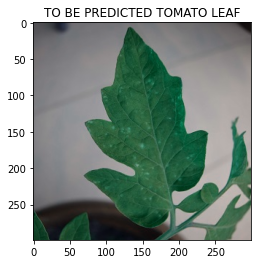

In [0]:
plt.imshow(cv2.imread('tomat.jpg'))
plt.title("TO BE PREDICTED TOMATO LEAF")
plt.show()

In [0]:
predict(img)

Tomato___Bacterial_spot 1.0
Tomato___Early_blight 0.0
Tomato___Late_blight 0.0
Tomato___Leaf_Mold 0.0
Tomato___Septoria_leaf_spot 0.0
Tomato___Spider_mites Two-spotted_spider_mite 0.0
Tomato___Target_Spot 0.0
Tomato___Tomato_Yellow_Leaf_Curl_Virus 0.0
Tomato___Tomato_mosaic_virus 0.0
Tomato___healthy 0.0

The image is predicted to be positive for : Tomato___Bacterial_spot disease


In [0]:
%time

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs
